# Cleaning data and creating custom features for Give Me Some Credit Kaggle Challenge

1. Cleaning the monthly income from NA values
2. Clean the debt ratio by replacing NA by the mean (Should ideally be done after splitting and the mean should be calculated on the training set if you want to do an evaluation)
3. Creating a montlhy debt feature
    * monthly income multiplied by debt ratio if income is not 0
    * debt ratio if income is 0
4. Create a Balanced Income feature that take into account Income and debt ratio
    * Set income to 0 when negative.
5. Clean the number of dependents feature
    * set NA to zero
6. Create a Blanced Income per household members feature
7. Cleaning the Number of Times Late feature
    * Create a custom categorical feature that contains 2 different tags for each row that contains a Number of time late of either 96 or 98
    * Remove the 96 and 98 values (Replacing those values by NA or some other justifiable value)
8. Add a feature that compute the weighted sum of the number of time late per duration
    * weight of 3 for 90 days and more
    * weight of 2 for 60 to 89 days
    * weight of 1 for 30 to 59 days


In [574]:
from pandas import DataFrame, read_csv, to_numeric
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from bigml.api import BigML
import kaggle

%matplotlib inline

In [ ]:
validation = True   #Do we split the data?
compression = True  #Do we compress the csv files?
send_to_BigML = True
build_model = True

version='v1.3'


## Loading csv files as data frames

Files must be placed in the same directory as this file. Alternatively, modify the relative path to those files.

In [ ]:
!pwd
!ls
fulltrain=read_csv('./cs-training.csv',index_col=0)
test=read_csv('./cs-test.csv',index_col=0)

## Reordering the objective field column to the end

In [ ]:
print(list(fulltrain))
fulltrain=fulltrain[[c for c in fulltrain if c != 'SeriousDlqin2yrs']+['SeriousDlqin2yrs']]
print(list(fulltrain))
if not validation:
    test=test[[c for c in fulltrain if c != 'SeriousDlqin2yrs']+['SeriousDlqin2yrs']]

In [ ]:
if(validation==True):
    train80, test20 = train_test_split(fulltrain, test_size=0.2)
    data_sets=[train80,test20]
else:
    data_sets=[fulltrain,test]

## Correcting the values in monthly income
Set NaN to 0 in the monthly income column

In [ ]:
help(DataFrame.fillna)

In [ ]:
for df in data_sets:
    df.loc[:,'MonthlyIncome'].fillna(0, inplace=True)
    
data_sets[0].head(10)

## Cleaning Debt ratio
Set NA values to the mode from the training set

In [ ]:
mode_debt_ratio=data_sets[0]['DebtRatio'].mode

for df in data_sets:
    df.loc[:,'DebtRatio'].fillna(mode_debt_ratio, inplace=True)
    
data_sets[0].head(20)

## Creating a new column for monthly debt.

In [ ]:
help(DataFrame.insert)

In [ ]:
for df in data_sets:
    df.insert(5,"MonthlyDebt",0)
data_sets[0].head(10)

If there is no income set DebtRatio to the mean debt ratio.

In [ ]:
for df in data_sets:
    df.loc[:,'MonthlyDebt']=df['DebtRatio']*df['MonthlyIncome']
    df.loc[df['MonthlyIncome'] == 0,'MonthlyDebt']=df.loc[df['MonthlyIncome'] == 0,'DebtRatio']
    #df.loc[df['MonthlyIncome'] == 0,'AbsoluteDebt']=df.loc[df['MonthlyIncome'] == 0,'DebtRatio'] #0.86222
    
    #df.loc[df['MonthlyIncome'] == 0,'DebtRatio']=0 #0.85533
    df.loc[df['MonthlyIncome'] == 0,'DebtRatio']=None #0.8610
    #df.loc[df['MonthlyIncome'] == 0,'DebtRatio']=mode_debt_ratio #0.8517

data_sets[0][['MonthlyDebt','DebtRatio','MonthlyIncome']].head(10)

## Creating a balanced Income feature

In [ ]:
for df in data_sets:
    #df.insert(6,'BalancedIncome',0)
    df.insert(6,'BalancedIncome',None)

In [ ]:
for df in data_sets:
    income_positive = df['MonthlyIncome'] > df['MonthlyDebt']
    df.loc[income_positive,'BalancedIncome']= df.loc[income_positive,'MonthlyIncome'] - df.loc[income_positive,'MonthlyDebt']

data_sets[0].head(20)

## Cleaning the number of dependents column
Set to 0 the number of dependents when not available.

In [ ]:
for df in data_sets:
    df.loc[:,'NumberOfDependents'].fillna(0, inplace=True)
    df.loc[:,'NumberOfDependents']=to_numeric(df['NumberOfDependents'],downcast='integer')
    
data_sets[0][['NumberOfDependents']].head(10)

## Add a balanced income per household members feature

In [ ]:
for df in data_sets:
    df.insert(7,'IncomePerHouseholdMember',0)

In [ ]:
for df in data_sets:
    df.loc[:,'IncomePerHouseholdMember']= df['BalancedIncome'] / (df['NumberOfDependents']+1)
data_sets[0][['IncomePerHouseholdMember']].head(20)

## Adding a "number of times late" categorical feature

In [ ]:
for df in data_sets:
    df.insert(8,'LateCategory',0)

In [ ]:
data_sets[0].loc[data_sets[0]['NumberOfTimes90DaysLate']==98,['LateCategory','NumberOfTimes90DaysLate']].head(20)

In [ ]:
for df in data_sets:
    df.loc[:,'LateCategory']="L0"
    df.loc[df['NumberOfTimes90DaysLate'] == 98,'LateCategory']="L98"
    df.loc[df['NumberOfTimes90DaysLate'] == 96,'LateCategory']="L96"
    df.loc[(df['NumberOfTimes90DaysLate'] == 98) | (df['NumberOfTimes90DaysLate'] == 96),
              ['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]=None
              
data_sets[0].loc[(data_sets[0]['LateCategory']=='L96') | (data_sets[0]['LateCategory']=='L98'),['LateCategory','NumberOfTimes90DaysLate']].head(20)

## Add a "Late score" feature

In [ ]:
for df in data_sets:
    df.insert(0,'LateScore',0)

In [ ]:
weight=[1,2,3]
#weight=[1,2,4]
for df in data_sets:
    df.loc[:,'LateScore']=weight[2]*df['NumberOfTimes90DaysLate']+weight[1]*df['NumberOfTime60-89DaysPastDueNotWorse']+weight[0]*df['NumberOfTime30-59DaysPastDueNotWorse']
    
data_sets[0][['LateScore']].head(10) 

## Remove the features we don't need

In [ ]:
print(list(data_sets[0]))

In [ ]:
for df in data_sets:
    df.drop('NumberOfTime30-59DaysPastDueNotWorse', axis=1, inplace=True)
    df.drop('NumberOfTime60-89DaysPastDueNotWorse', axis=1, inplace=True)
    df.drop('NumberOfTimes90DaysLate', axis=1, inplace=True)
    df.drop('NumberOfDependents', axis=1, inplace=True)

In [ ]:
print(list(data_sets[0]))

## Save the data frames as csv files

In [ ]:
if compression:
    compress='.bz2'
else:
    compress=''

filenames = ["",""]
    
if validation:
    filenames[0]= 'gmsc-train80-' + version + '.csv'+ compress
    filenames[1]= 'gmsc-valid20-' + version + '.csv'+ compress
else:
    filenames[0]= 'gmsc-fulltrain-' + version + '.csv'+ compress
    filenames[1]= 'gmsc-test-' + version + '.csv'+ compress

for i in range(0,2):
    data_sets[i].to_csv(filenames[i],index_label='Id')
                        
print("Done")

## Send the data to BigML and create an ensemble model

In [ ]:
if send_to_BigML:
    api = BigML(project='project/5d94a428eba31d460c00023f')

    if validation:
        train_src = api.create_source('gmsc-train80-' + str(version) + '.csv'+ compress)
        api.ok(train_src)
        test_src = api.create_source('gmsc-valid20-' + str(version) + '.csv'+ compress)
        api.ok(test_src)
    else:
        train_src = api.create_source('gmsc-fulltrain-' + str(version) + '.csv' + compress)
        api.ok(train_src)
        test_src = api.create_source('gmsc-test-' + str(version) + '.csv' + compress)
        api.ok(test_src)

    print("Sources created")

In [ ]:
if send_to_BigML:
    train_ds = api.create_dataset(train_src)
    api.ok(train_ds)
    test_ds = api.create_dataset(test_src)
    api.ok(test_ds)
    print("Data sets created")
    model_args= {"objective_field": "SeriousDlqin2yrs"}
    model = api.create_ensemble(train_ds, model_args)
    api.ok(model)
    print("Model created")

## Validation or test batch prediction

In [ ]:
if validation and send_to_BigML:
    evaluation = api.create_evaluation(model, test_ds)
    api.ok(evaluation)
    api.pprint(evaluation['object']['result'])
#else:

In [ ]:
prediction_file='./gsmc_predictions-{}.csv'.format(version)

In [ ]:

if send_to_BigML:
    batch_prediction = api.create_batch_prediction(model, test_ds, {
        "name": "my batch prediction" + version,
        "all_fields": True,
        "header": True,
        "confidence": True,
        "probabilities": True}                      )
    api.ok(batch_prediction)
    api.download_batch_prediction(batch_prediction,
                                filename=prediction_file)
    print('batch prediction:Done')

Open BigML predictions

In [709]:
prediction=read_csv(prediction_file,index_col=False)

In [746]:
if validation and send_to_BigML:
    score = roc_auc_score(prediction['SeriousDlqin2yrs'].values,prediction['1 probability'].values)
    print(score)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10.7 ms
0.8535801266514811


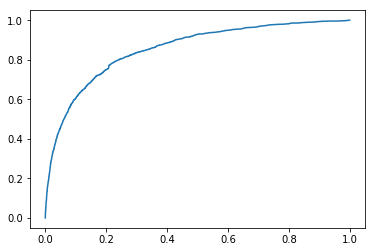

In [570]:
if validation and send_to_BigML:
    fpr, tpr, thresholds = roc_curve(prediction['SeriousDlqin2yrs'],prediction['1 probability'])
    plt.plot(fpr, tpr)

## Validation analysis

In [706]:
if validation:
    prediction['absolute_error']=(prediction['1 probability']-prediction['SeriousDlqin2yrs']).abs()
    prediction = prediction.sort_values(by='absolute_error', ascending=False).head(100)


In [551]:
if validation:
    TP_lines = (prediction['SeriousDlqin2yrs']==1) & (prediction['SeriousDlqin2yrs.1']==1)
    TN_lines = ~(prediction['SeriousDlqin2yrs']==1) & ~(prediction['SeriousDlqin2yrs.1']==1)
    FP_lines = ~(prediction['SeriousDlqin2yrs']==1) & (prediction['SeriousDlqin2yrs.1']==1)
    FN_lines = (prediction['SeriousDlqin2yrs']==1) & ~(prediction['SeriousDlqin2yrs.1']==1)

    TP = len(prediction.loc[TP_lines])
    TN = len(prediction.loc[TN_lines])
    FP = len(prediction.loc[FP_lines])
    FN = len(prediction.loc[FN_lines])
    print(f'TP={TP}')
    print(f'TN={TN}')
    print(f'FP={FP}')
    print(f'FN={FN}')


TP=363
TN=27682
FP=237
FN=1718


In [579]:
def cost_threshold(threshold):
    prediction_threshold = prediction['1 probability'] > threshold

    P_pred = prediction_threshold
    N_pred = ~prediction_threshold

    P_real = (prediction['SeriousDlqin2yrs'] == 1)
    N_real = (prediction['SeriousDlqin2yrs'] == 0)

    TP = len(prediction.loc[P_pred & P_real])
    TN = len(prediction.loc[N_pred & N_real])
    FP = len(prediction.loc[P_pred & N_real])
    FN = len(prediction.loc[N_pred & P_real])

    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500

    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost

    return cost

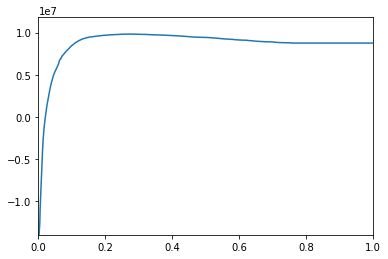

In [580]:
table = [cost_threshold(n/1000) for n in range(0,1000)]
threshold = [n/1000 for n in range(0,1000)]
plt.axis([0, 1,min(table),1.2*max(table)])
plt.plot(threshold, table)
plt.show()

In [581]:
max_val = max(table)
max_threshold = table.index(max_val)/1000
print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

Le gain maximum est 9834500 et il est obtenu avec un seuil de 0.277


In [593]:
threshold_list = prediction['1 probability'].sort_values().values
threshold_intervals = []
for i in range(len(threshold_list)-1):
    midpoint=(threshold_list[i]+threshold_list[i+1])/2
    threshold_intervals.append(midpoint)
table = [cost_threshold(t) for t in threshold_intervals]

In [594]:
max_val = max(table)
max_threshold = threshold_intervals[table.index(max_val)]
print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

Le gain maximum est 9834500 et il est obtenu avec un seuil de 0.27679000000000004


## AUC computation by hand
### The naive way: fast to implement and slow to run.

Don't mind the limit case.

In [ ]:
TPR=[]
FPR=[]

threshold_list = prediction['1 probability'].sort_values().values

P_real = (prediction['SeriousDlqin2yrs'] == 1)
N_real = (prediction['SeriousDlqin2yrs'] == 0)
nb_P_real=len(prediction.loc[P_real])
nb_N_real=len(prediction.loc[N_real])

for t in threshold_list:
    prediction_threshold = prediction['1 probability'] > t

    P_pred = prediction_threshold
    N_pred = ~prediction_threshold

    TP = len(prediction.loc[P_pred & P_real])
    FP = len(prediction.loc[P_pred & N_real])

    TPR.append(TP/(nb_P_real))
    FPR.append(FP/(nb_N_real))

AUC=0
for i in range(len(TPR)-1):
    AUC+=(FPR[i]-FPR[i+1])*(TPR[i+1]+TPR[i])/2
print(AUC)

### Computing the auc by hand the pandas way

In [755]:
P_real = (prediction['SeriousDlqin2yrs'] == 1)
N_real = (prediction['SeriousDlqin2yrs'] == 0)
nb_P_real=len(prediction.loc[P_real])
nb_N_real=len(prediction.loc[N_real])

total=len(prediction)

df_threshold=DataFrame(index=prediction['1 probability'])
df_threshold['P_real'] = P_real.values
df_threshold['N_real'] = N_real.values
df_threshold['P']=prediction['SeriousDlqin2yrs'].values
df_threshold.sort_index(inplace=True, ascending=False)

TP_cumsum =  df_threshold['P_real'].cumsum()
TPR_next = TP_cumsum/nb_P_real #TPR right after threshold
TPR_prev = TPR_next.shift(1,fill_value=0) #TPR right before threshold

FP_cumsum =  df_threshold['N_real'].cumsum()
FPR_next = FP_cumsum/nb_N_real #FPR right after threshold
FPR_prev = FPR_next.shift(1,fill_value=0) #FPR right before threshold

auc = ((FPR_next-FPR_prev)*(TPR_prev+TPR_next)/2).sum()

print(f'AUC={auc}')
#df_threshold

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 5.02 ms
AUC=0.8535790164858562


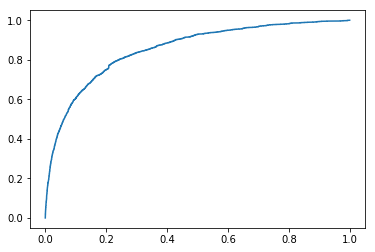

In [754]:
plt.plot(FPR_next,TPR_next)
plt.show()

## Send prediction to Kaggle

In [ ]:
kaggle_prediction=DataFrame()
if not validation:
    kaggle_prediction['Id']=prediction['Id']
    kaggle_prediction['Probability']=prediction['1 probability']
    kaggle_prediction_file="kaggleprediction.csv"
    kaggle_prediction.to_csv(kaggle_prediction_file,index=False)
    kaggle.api.competition_submit(kaggle_prediction_file, "Ensemble-" + str(version), "GiveMeSomeCredit")

In [ ]:
kaggle.api.competitions_submissions_list("GiveMeSomeCredit")[0]['publicScore']